In [1]:
%load_ext autoreload
%autoreload 2
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints
from multiboat_trajectory_optimization.boat_models import Boat, TwoInputBoat
from multiboat_trajectory_optimization.trajectory_planner import BoatConfigurationPlanning, B_i_k, knots_to_trajectory

### Composing Shapes from Blocks

In [2]:

shape_a = Shape([Block(-0.75,0.5,90),Block(0,0.25,0),Block(1,0.25,0),Block(1.75,.5,90)])
shape_b = Block(0,0.25)

#shape_a.polygon

In [3]:
#shape_b.plot(union=False)

In [4]:
#shape_a.plot(union=False)

### Partitioning of convex hulls around shape

In [47]:
hulls = shape_a.partition_around(buffered=False)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

In [48]:
ab = shape_a.c_space(shape_b)
#ab.plot(union=True)

### Finding Convex Hull of C-Space

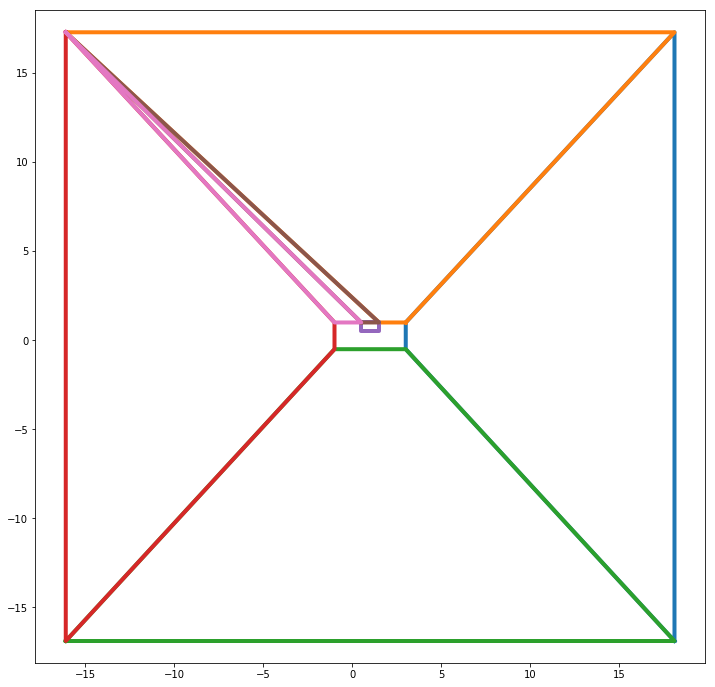

In [49]:
hulls = ab.partition_around(buffered=False)
ab.plot_polygons(hulls)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


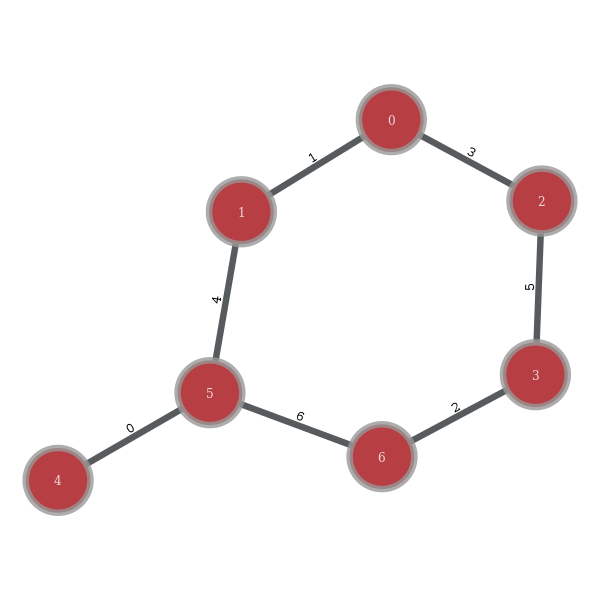

In [50]:
%load_ext autoreload
%autoreload 2
g = HullGraph(hulls)
g.draw_graph()

## Trajectory Planning

In [80]:
%load_ext autoreload
%autoreload 2
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints

def experiment(boat_shape, obstacle_shape, xy0, xyN, margin=0, boat_type=ShapeBoat):
    x0 = np.zeros((1, Boat.num_states))
    xN = np.zeros((1, Boat.num_states))
    x0[0, :2] = xy0
    xN[0, :2] = xyN
    boat = boat_type(boat_shape, obstacle_shape)
    boat.set_end_points(x0, xN)
    planner = BoatConfigurationPlanning(boat)
    boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_trajectory(0., 10, x0, xN, time_cost=False, input_cost=True, slack=0, N=100)
    return boat, boats_S, boats_U

def experiment_spline(boat_shape, obstacle_shape, xy0, xyN, N=10, margin=0, boat_type=ShapeBoat_spline):
    x0 = np.zeros((1, Boat.num_states))
    xN = np.zeros((1, Boat.num_states))
    x0[0, :2] = xy0
    xN[0, :2] = xyN
    boat = boat_type(boat_shape, obstacle_shape)
    boat.set_end_points(x0, xN)
    planner = BoatConfigurationPlanning(boat)
    boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_spline_trajectory(0., 20, x0, xN, input_cost=True, slack=0, N=N)
    return boat, boats_S, boats_U, mp

def write_experiment(boat, boats_S, boats_U, label):
    with open('results/path_'+label+'.pickle', 'wb') as f:
        pickle.dump([boat,boats_S,boats_U], f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MIQP - b-splines

INITIALIZED 1 ShapeBoat_spline boats
boats_S:(1, 6, 4), boats_U:(1, 5, 2), time_array:(6,)
Number of decision vars 34
0.002200 seconds
ADDING COSTS
0.006032 seconds
ADDING CONSTRAINTS
True
0.024640 seconds
PLANNING
SolutionResult.kSolutionFound
0.095528 seconds



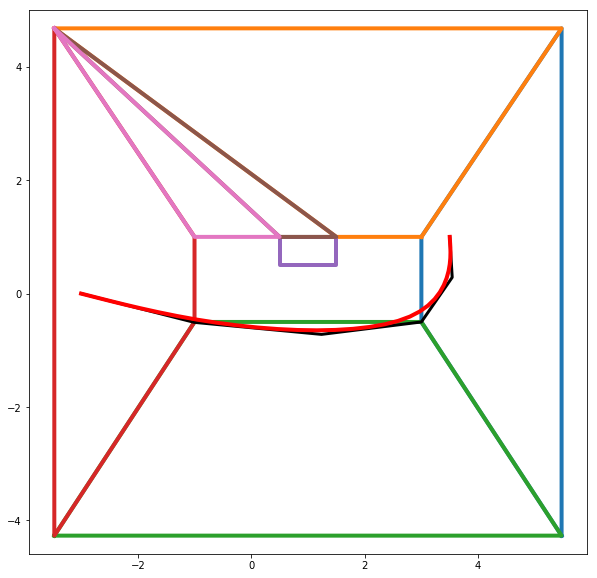

In [81]:
boat, boats_S, boats_U, mp = experiment_spline(shape_b, shape_a, [-3,0], [3.5,1], N=5)
#boats_S = np.array([[[0.,1.],[0.1,1.5],[0.5,2.0],[0.6,-1.],[-1., -2.], [-3.,-3.]]])
boats_S_new = knots_to_trajectory(boats_S, 43)

plt.figure(figsize=(10,10))
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False, figure=False)
plt.plot(boats_S_new[0,:,0], boats_S_new[0,:,1], color='red', linewidth='4')
plt.show()

In [50]:
mp.GetSolution(boat.a)
print mp.GetSolution(boat.on_edge)
print mp.GetSolution(boat.in_hull)

[[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [-0.  0.  0.  0.]
 [-0.  1.  0.  0.]
 [ 0.  0.  0. -0.]
 [ 0.  0.  0.  1.]]


## MIQP - Euler

### Shape B around Shape A

In [17]:
boat, boats_S, boats_U = experiment(shape_b, shape_a, [5,0], [-2.5,.51])

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.002760 seconds
ADDING COSTS
0.012113 seconds
ADDING CONSTRAINTS
True
0.213016 seconds
PLANNING
SolutionResult.kSolutionFound
1.543476 seconds



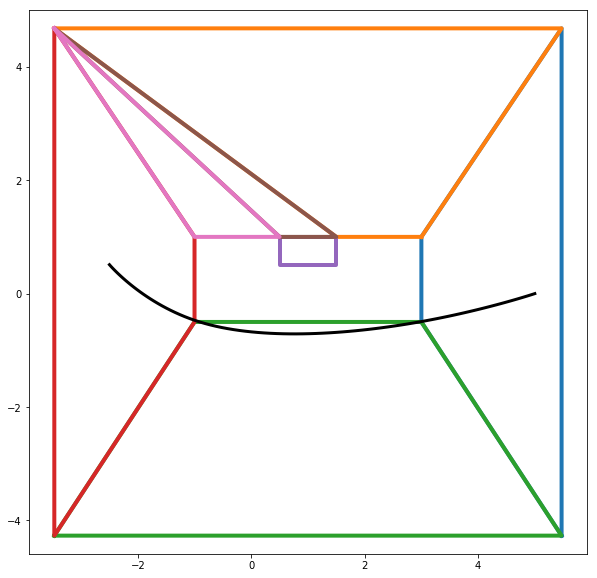

[0, 2, 3]


In [18]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B around shape B

In [665]:
boat, boats_S, boats_U = experiment(shape_b, shape_b, [0,3], [0,-3])
write_experiment(boat, boats_S, boats_U, 'avoid')

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.002735 seconds
ADDING COSTS
0.013012 seconds
ADDING CONSTRAINTS
True
0.253831 seconds
PLANNING
SolutionResult.kSolutionFound
2.435190 seconds



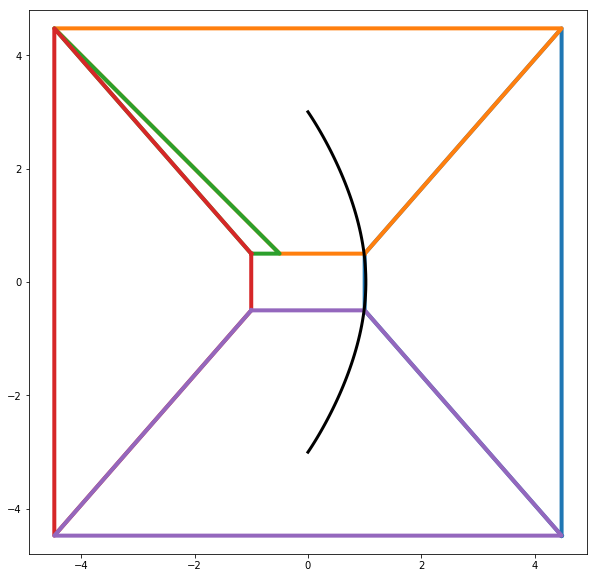

[1, 0, 4]


In [666]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B latch to Shape B

In [667]:
boat, boats_S, boats_U = experiment(shape_b, shape_b, [1,3], [0,0.51])
write_experiment(boat, boats_S, boats_U, 'latch')

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.003489 seconds
ADDING COSTS
0.014576 seconds
ADDING CONSTRAINTS
True
0.191763 seconds
PLANNING
SolutionResult.kSolutionFound
0.026942 seconds



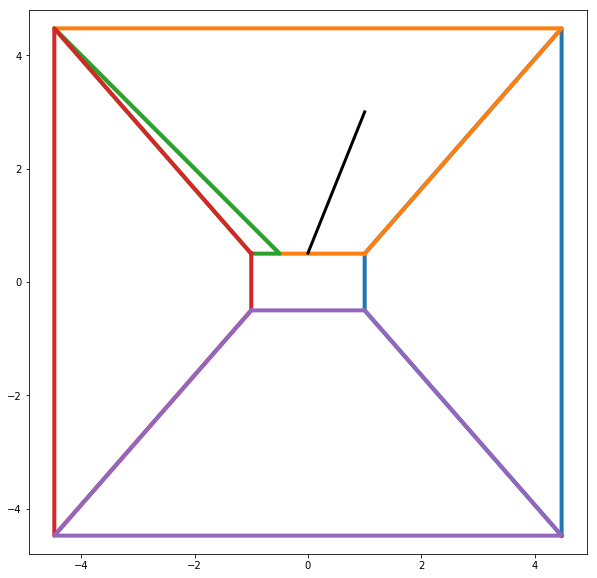

[1]


In [668]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path